# DEMO: JKI and JKI-CODE-DE DataCubes
## Sentinel-2, PHASE and precipitation

### necessary packages 

In [1]:
# import own functions
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from datetime import datetime
import rasterio
import io
from tqdm.notebook import tqdm
import time

### important functions

In [2]:
'''
the actual function to request something from Rasdaman are stored in the file functions_Nalamki.py
'''
from functions_DataCube import *

### credentials from credentials.py

In [3]:
'''
First you have to generate file called credentials.py
file content:

ras_user = 'your user name'
ras_pw = 'your password'
ras_host = '192.168.206.30'

'''
import credentials # ---> this is the credentials.py

if credentials.ras_cde_user == '' or credentials.ras_cde_pw == '':
    print('First, you need to add your personal user name and/or password to the credentials.py')
else:
    print('credentials set!')

credentials set!


# Example Winter Wheat field in 2020

In [4]:
# directory to shape file of agricultural field'
shp = 'Vector/winterwheat2020.shp'

In [5]:
### shows vector in an interactive map
## works only if you installed ipyleaflet
get_map(shp, zoom=15)

Map(center=[52.20607611445891, 10.39525994822609], controls=(ZoomControl(options=['position', 'zoom_in_text', …

# Collecting PHASE data from JKI DataCube

Citataion of PHASE data:  
Möller, M., Boutarfa, L., & Strassemeyer, J. (2020). PhenoWin – An R Shiny application for visualization and extraction of phenological windows in Germany. Computers and Electronics in Agriculture, 175, 105534. https://doi.org/10.1016/j.compag.2020.105534

In [6]:
print('Potiential starting dates of phenological phases for winter wheat:\n')
# get centroid coodinates from field
easting = float(gpd.read_file(shp).to_crs('EPSG:32632').centroid.x)
northing = float(gpd.read_file(shp).to_crs('EPSG:32632').centroid.y)

# phenological phases for winter wheat
p_names = ['shooting','heading', 'milk ripening','yellow ripening','harvest', 'sowing', 'emergence']

# get phases from previous year
year_pre = '2019'
days_pre = get_all_dates(year_pre)

# wcs request:
phases_pre = get_phases_from_point(
    year=year_pre,
    crop='winterwheat',
    easting=easting,
    northing=northing,
    epsg=32632,
    host=credentials.ras_host,
    printout=False,
    get_query=False
)

# print result for previous year (sowing and emegrence)
for i in range(-2,0):
    print('{} started on DOY {} in year {}'.format(p_names[i], int(phases_pre[i]), year_pre))

# get phases from ongoing year
year_on = '2020'    
days_on= get_all_dates(year_on)

# wcs request:
phases_on = get_phases_from_point(
    year=year_on,
    crop='winterwheat',
    easting=easting,
    northing=northing,
    epsg=32632,
    host=credentials.ras_host,
    printout=False,
    get_query=False
)

# print result for ongoing year (shooting - harvest)
for i in range(0,5):
    print('{} started on DOY {} in year {}'.format(p_names[i], int(phases_on[i]), year_on))


Potiential starting dates of phenological phases for winter wheat:

sowing started on DOY 277 in year 2019
emergence started on DOY 291 in year 2019
shooting started on DOY 106 in year 2020
heading started on DOY 144 in year 2020
milk ripening started on DOY 175 in year 2020
yellow ripening started on DOY 192 in year 2020
harvest started on DOY 206 in year 2020


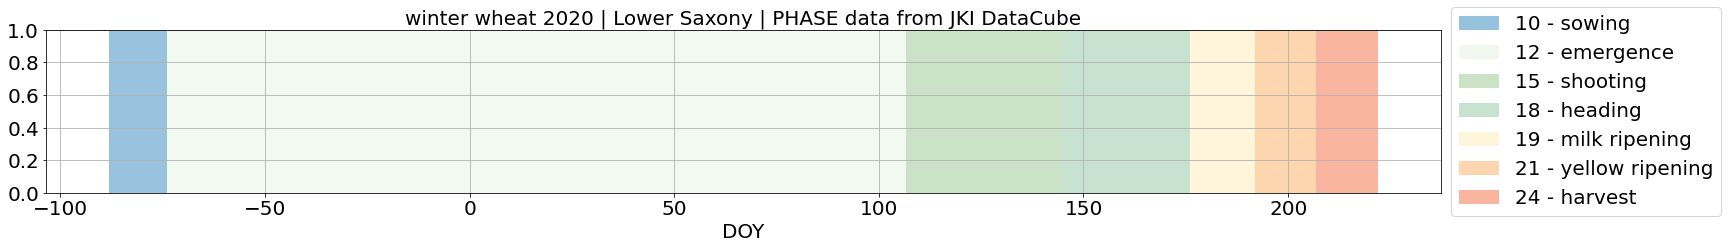

In [7]:
# plot phenological phases
fig, ax = plt.subplots(figsize=(25,3))

# get start of phases from previous year
sow = -1 * (len(days_pre) - np.floor(phases_pre[-2]))
eme = -1 * (len(days_pre) - np.floor(phases_pre[-1]))

ax.axvspan(sow,eme , facecolor= '#3287BD', alpha=0.5, label='10 - sowing')
ax.axvspan(eme,phases_on[0] , facecolor= '#E6F4E3', alpha=0.5, label='12 - emergence')
# ax.axvspan(0, phases[0], facecolor= '#E6F4E3', alpha=0.5, label='emergence')
ax.axvspan(phases_on[0], phases_on[1], facecolor= '#9AC693', alpha=0.5, label='15 - shooting')
ax.axvspan(phases_on[1], phases_on[2], facecolor= '#93C7A3', alpha=0.5, label='18 - heading')
ax.axvspan(phases_on[2], phases_on[3], facecolor= '#FEEDB9', alpha=0.5, label='19 - milk ripening')
ax.axvspan(phases_on[3], phases_on[4], facecolor= '#FDAE61', alpha=0.5, label='21 - yellow ripening')
ax.axvspan(phases_on[4], phases_on[4]+15, facecolor= '#F56D43', alpha=0.5, label='24 - harvest')
ax.grid()
ax.set_xlabel('DOY', fontsize=20)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('winter wheat 2020 | Lower Saxony | PHASE data from JKI DataCube', fontsize=20)
plt.savefig('/media/data_storage/data_storage/florian/projects/DEMO_Rasdaman/winterwheat_field_2020_PHASES.pdf',bbox_inches='tight')
plt.show()



In [8]:
sowing = int(np.floor(phases_pre[-2]))
print('start of sowing (DOY): ', sowing)

start of sowing (DOY):  277


In [9]:
print('number of days from sowing to the last day of the previous year: ', len(days_pre)-sowing)

number of days from sowing to the last day of the previous year:  88


In [10]:
harvest = int(np.ceil(phases_on[4]))+15
print('start of harvest (DOY): {}\nend of harvest set to (DOY): {}'.format(int(np.ceil(phases_on[4])), harvest))

start of harvest (DOY): 207
end of harvest set to (DOY): 222


# Collecting earth observation date (vegetation index: SAVI) from JKI-CODE-DE DataCube

In [11]:
%%time

'''
This cell collects all available Sentinel-2 images available for the agricultural field.
The SAVI will be calculated in case the valid pixel portion is satisfied...
First, the previous year (2019) will be treated from sowing to the last day of the year, then the ongoing (target) year (2020) till the harvest period.
'''

# choose a minimum portion of valid pixels within the image [in %]
valid_pixels = 40

# first loop --> all available images from previous year
dict_field = {}
for i, day in enumerate(tqdm(days_pre[sowing:])):
    # requesing DataCube
    img = get_tif_rasdaman(
        shp,
        endpoint=credentials.ras_cde_host,
        user=credentials.ras_cde_user,
        pw=credentials.ras_cde_pw,
        layer='S2_GermanyGrid',
        rDate=day,
        band1='NIR10',
        band2='R',
        band3='G',
        printout=False,
        get_query=False
    )
    
    # calculating SAVI
    index = calculate_savi(img, valid_pixel_portion=valid_pixels)
    if isinstance(index, list):
        dict_field[day] = [index[0], index[1], i-(len(days_pre)-sowing)]            
    
# second loop --> all available images from previous year
for i, day in enumerate(tqdm(days_on[:harvest])):
    # requesing DataCube
    img = get_tif_rasdaman(
        shp,
        endpoint=credentials.ras_cde_host,
        user=credentials.ras_cde_user,
        pw=credentials.ras_cde_pw,
        layer='S2_GermanyGrid',
        rDate=day,
        band1='NIR10',
        band2='R',
        band3='G',
        printout=False,
        get_query=False
    )
    
    # calculating SAVI
    index = calculate_savi(img, valid_pixel_portion=valid_pixels)
    if isinstance(index, list):
        dict_field[day] = [index[0], index[1], i+1]
    

  0%|          | 0/88 [00:00<?, ?it/s]

'/vsimem/4e7f6b4d-a13c-4308-8139-7fe325fed322/4e7f6b4d-a13c-4308-8139-7fe325fed322.tif' not recognized as a supported file format.


  0%|          | 0/222 [00:00<?, ?it/s]

'/vsimem/57df3daa-d79a-4d34-8d07-f662abdb16a5/57df3daa-d79a-4d34-8d07-f662abdb16a5.tif' not recognized as a supported file format.
CPU times: user 24.4 s, sys: 1.2 s, total: 25.6 s
Wall time: 1min 10s


In [12]:
print('number of extracted fields: ', len(dict_field))

number of extracted fields:  44


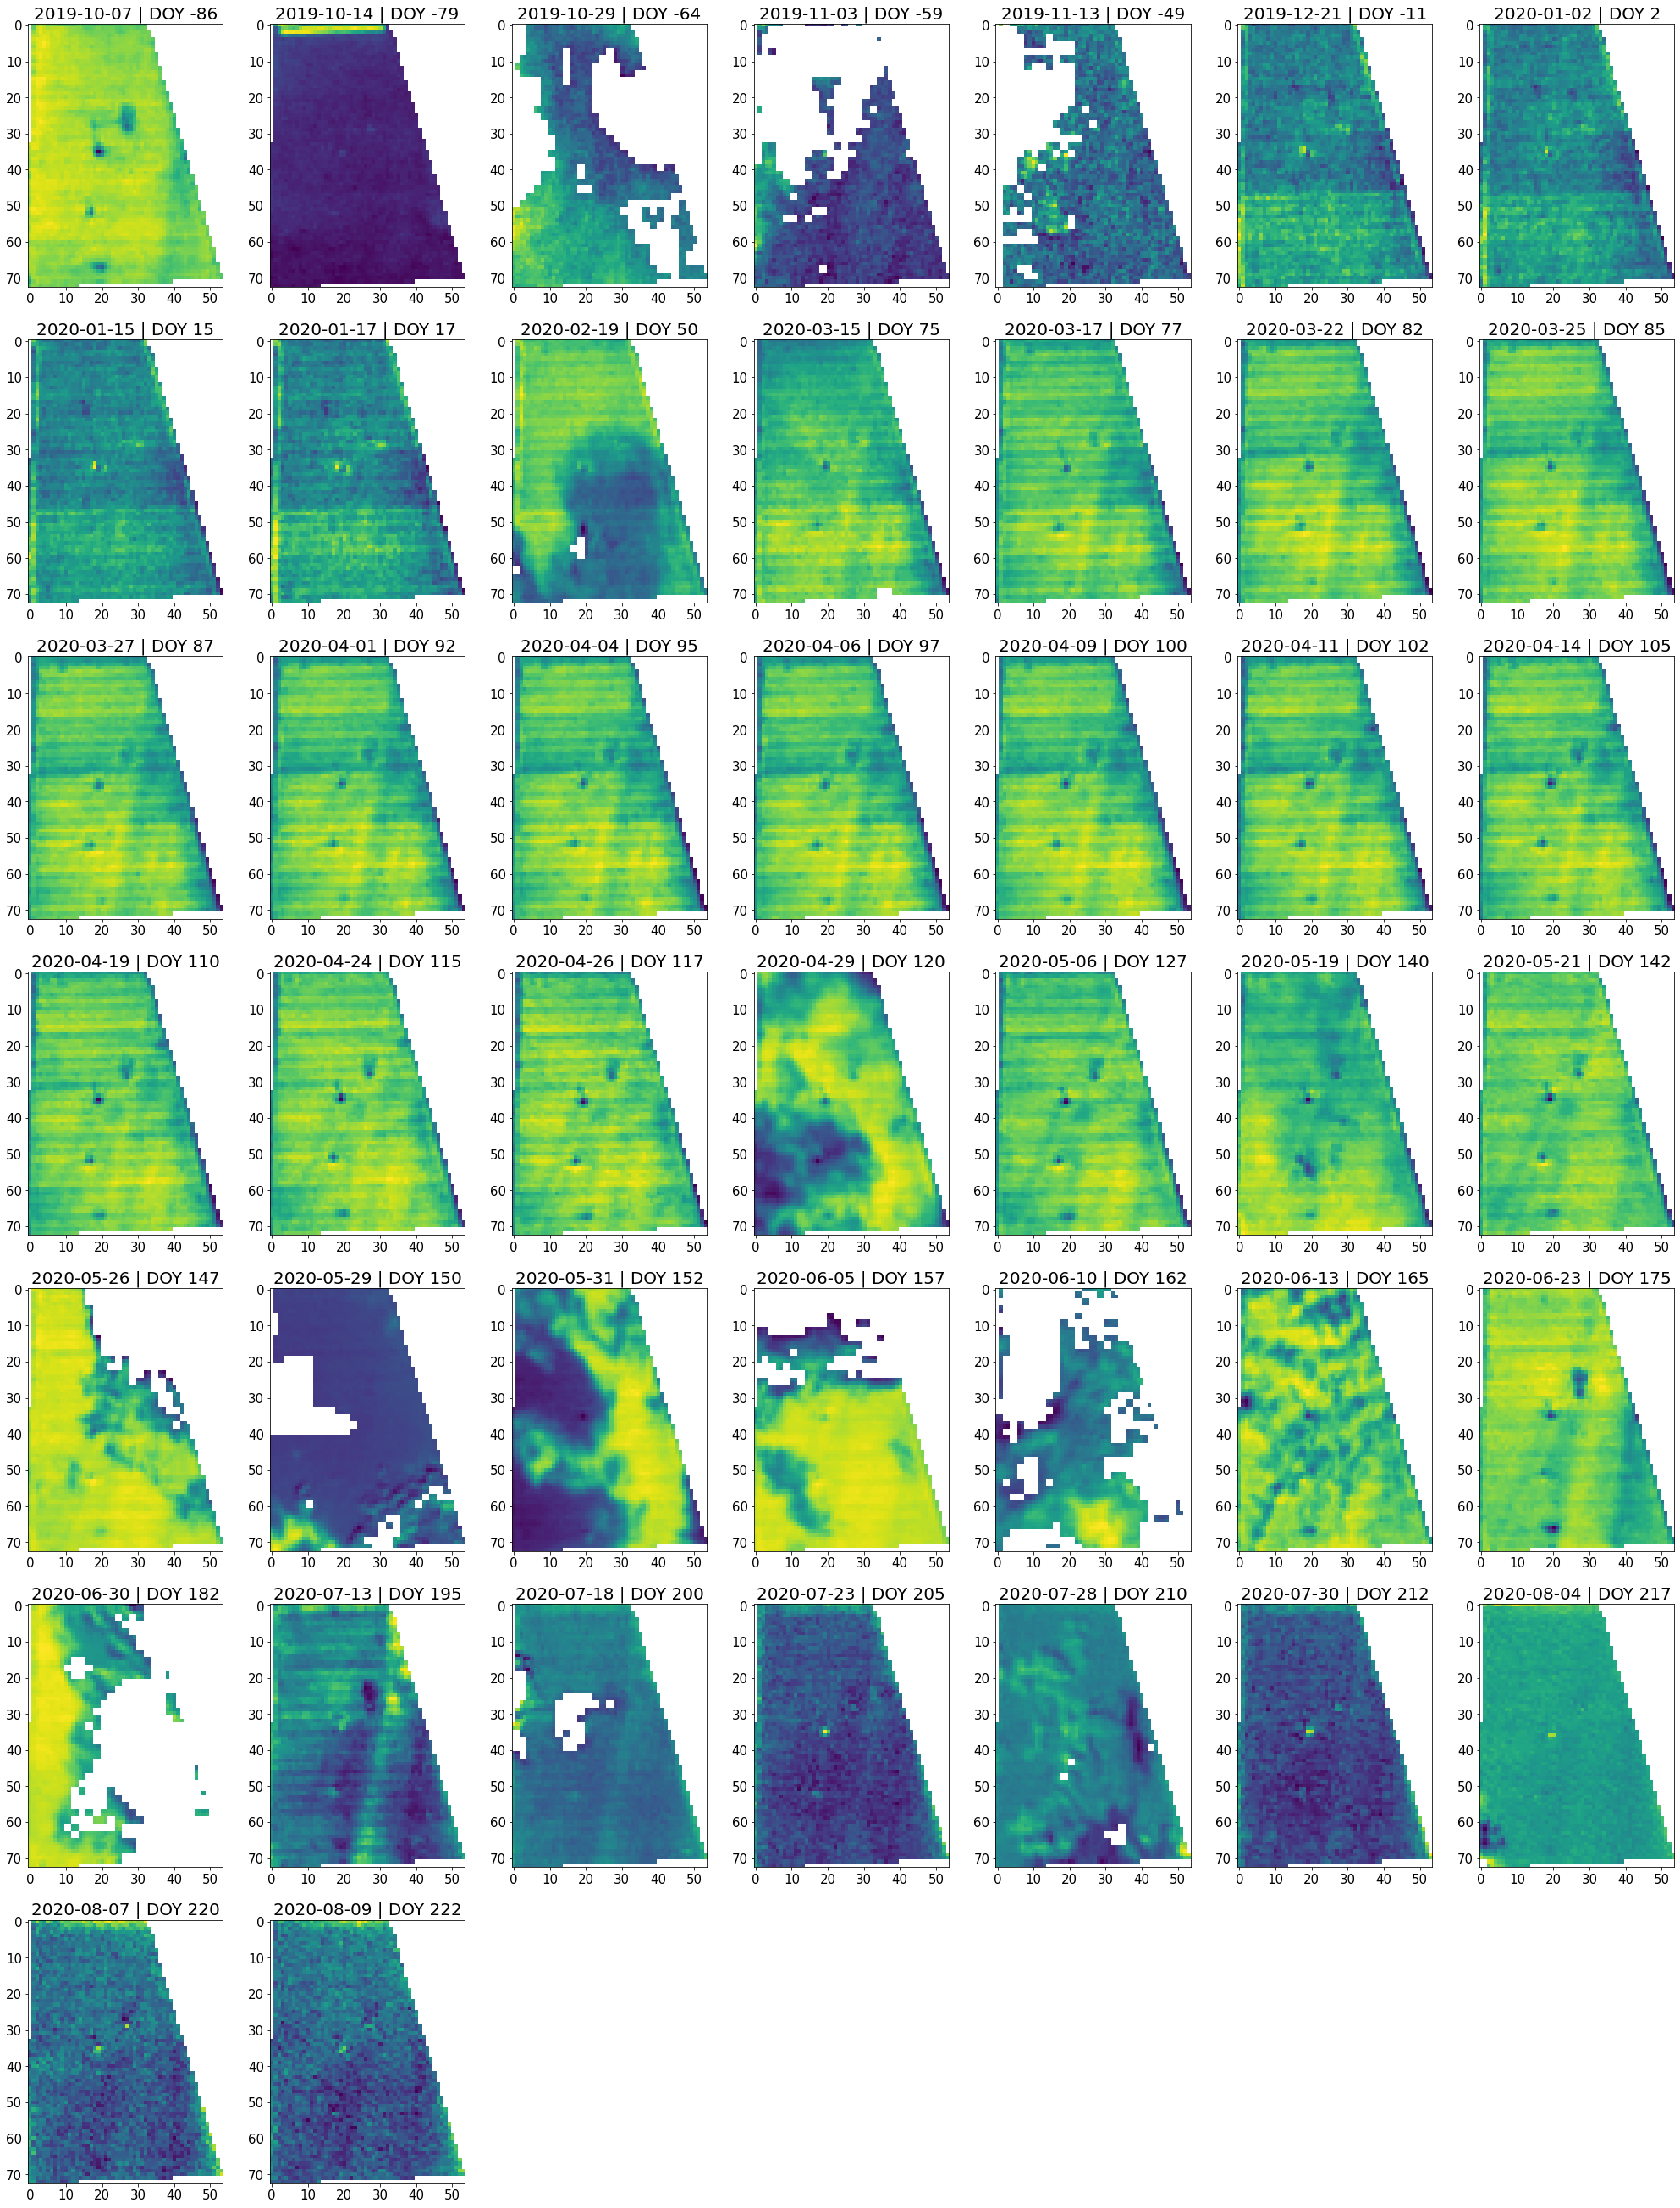

In [13]:
cols = 7
rows = int(np.ceil(len(dict_field)/2))
fig = plt.figure(figsize=(35,150))
for i, date in enumerate(dict_field):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(dict_field[date][0])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(date+' | DOY '+str(dict_field[date][2]), fontsize=20)
plt.savefig('/media/data_storage/data_storage/florian/projects/DEMO_Rasdaman/winterwheat_field_2020_SAVI_dates.pdf',bbox_inches='tight')
plt.show()

# Collecting precipitation data (REGNIE) from JKI DataCube

In [14]:
%%time
# requesing precipitation data from previous year
regnie_pre = get_REGNIE_from_point(
    startdate=days_pre[0],
    enddate=days_pre[-1],
    layer='REGNIE',
    easting=easting,
    northing=northing,
    epsg=32632,
    user=credentials.ras_user,
    passwd=credentials.ras_pw,
    host=credentials.ras_host,
    printout=True,
    get_query=True
)
print('annual precipitation sum = {} mm\n'.format(np.sum(regnie_pre)))

https://datacube.julius-kuehn.de/flf/ows?&SERVICE=WCS&VERSION=2.0.1&REQUEST=GetCoverage&COVERAGEID=REGNIE&SUBSET=ansi("2019-01-01","2019-12-31")&SUBSET=Lon(10.395259970381245)&SUBSET=Lat(52.20607607938829)&FORMAT=text/csv
request was sucessfull! Request Status: 200
annual precipitation sum = 543.6 mm

CPU times: user 62.6 ms, sys: 7.19 ms, total: 69.8 ms
Wall time: 18.9 s


In [15]:
%%time
# requesing precipitation data from ongoing year
regnie_on = get_REGNIE_from_point(
    startdate=days_on[0],
    enddate=days_on[-1],
    layer='REGNIE',
    easting=easting,
    northing=northing,
    epsg=32632,
    user=credentials.ras_user,
    passwd=credentials.ras_pw,
    host=credentials.ras_host,
    printout=True,
    get_query=True
)
print('annual precipitation sum = {} mm'.format(np.sum(regnie_on)))

https://datacube.julius-kuehn.de/flf/ows?&SERVICE=WCS&VERSION=2.0.1&REQUEST=GetCoverage&COVERAGEID=REGNIE&SUBSET=ansi("2020-01-01","2020-12-31")&SUBSET=Lon(10.395259970381245)&SUBSET=Lat(52.20607607938829)&FORMAT=text/csv
request was sucessfull! Request Status: 200
annual precipitation sum = 527.1 mm
CPU times: user 72.9 ms, sys: 3.63 ms, total: 76.6 ms
Wall time: 19.2 s


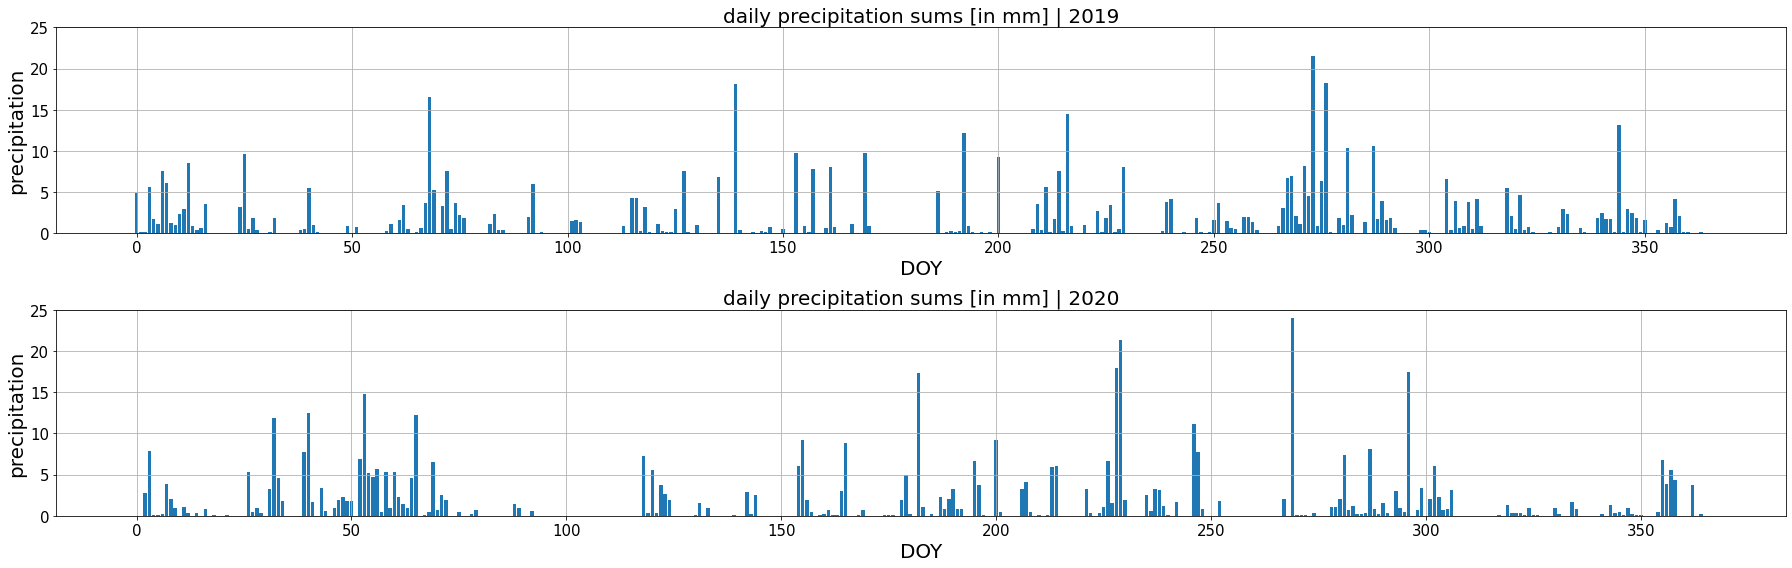

In [16]:
# plotting precipitation of both years

fig, axs = plt.subplots(2, 1, figsize=(25,8))
# plt.figure(figsize=(25,2))
axs[0].bar(range(len(regnie_pre)), regnie_pre)
axs[0].grid()
axs[0].set_title('daily precipitation sums [in mm] | 2019', fontsize = 20)
axs[0].set_xlabel('DOY', fontsize = 20)
axs[0].set_ylabel('precipitation', fontsize = 20)
axs[0].set_ylim(0,25)
axs[0].xaxis.set_tick_params(labelsize=15)
axs[0].yaxis.set_tick_params(labelsize=15)

axs[1].bar(range(len(regnie_on)), regnie_on)
axs[1].grid()
axs[1].set_title('daily precipitation sums [in mm] | 2020', fontsize = 20)
axs[1].set_xlabel('DOY', fontsize = 20)
axs[1].set_ylabel('precipitation', fontsize = 20)
axs[1].set_ylim(0,25)
axs[1].xaxis.set_tick_params(labelsize=15)
axs[1].yaxis.set_tick_params(labelsize=15)
fig.tight_layout()

plt.savefig('/media/data_storage/data_storage/florian/projects/DEMO_Rasdaman/winterwheat_field_2020_precipitation.pdf',bbox_inches='tight')
plt.show()

# Plotting all results

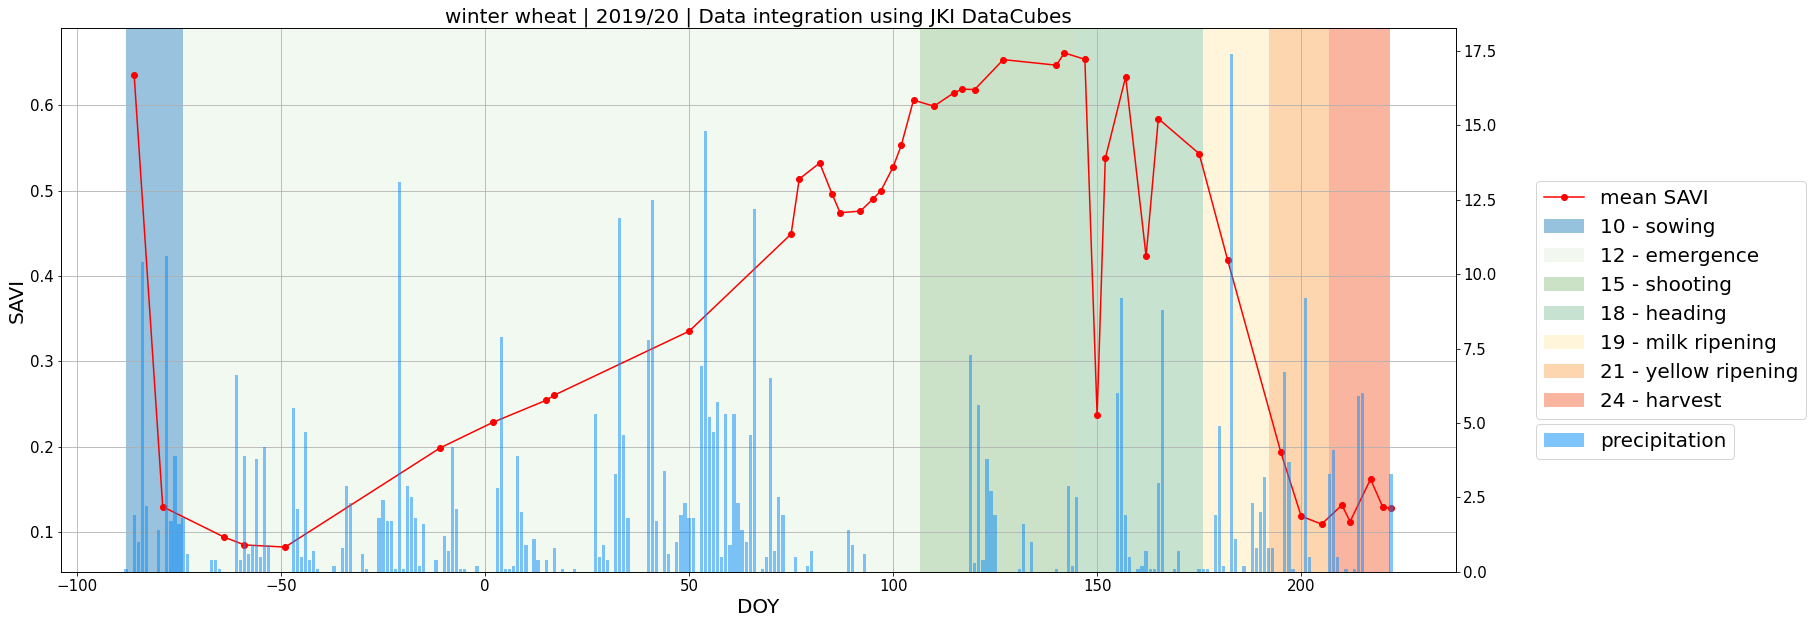

In [17]:
# calculating the mean SAVI of every aquisistion date
x = [] 
savi = []
for day in dict_field:
    x_ = dict_field[day][2]
    savi_ = np.nanmean(dict_field[day][0])
    x.append(x_)
    savi.append(savi_)

fig, ax = plt.subplots(figsize=(25,10))
ax.plot(x, savi, 'o-' ,c='red',label='mean SAVI')
sow = -1 * (len(days_pre) - np.floor(phases_pre[-2]))
eme = -1 * (len(days_pre) - np.floor(phases_pre[-1]))
ax.axvspan(sow,eme , facecolor= '#3287BD', alpha=0.5, label='10 - sowing')
ax.axvspan(eme,phases_on[0] , facecolor= '#E6F4E3', alpha=0.5, label='12 - emergence')
# ax.axvspan(0, phases[0], facecolor= '#E6F4E3', alpha=0.5, label='emergence')
ax.axvspan(phases_on[0], phases_on[1], facecolor= '#9AC693', alpha=0.5, label='15 - shooting')
ax.axvspan(phases_on[1], phases_on[2], facecolor= '#93C7A3', alpha=0.5, label='18 - heading')
ax.axvspan(phases_on[2], phases_on[3], facecolor= '#FEEDB9', alpha=0.5, label='19 - milk ripening')
ax.axvspan(phases_on[3], phases_on[4], facecolor= '#FDAE61', alpha=0.5, label='21 - yellow ripening')
ax.axvspan(phases_on[4], phases_on[4]+15, facecolor= '#F56D43', alpha=0.5, label='24 - harvest')
ax.grid()
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax2 = ax.twinx()
ax2.bar(np.array(range(int(sow),0)), regnie_pre[sowing:],alpha=0.5, color='#038cfc')
ax2.bar(np.arange(len(regnie_on[:harvest]))+1, regnie_on[:harvest],alpha=0.5, color='#038cfc', label='precipitation')
ax.set_ylabel('SAVI', fontsize=20)
ax.set_xlabel('DOY', fontsize=20)
ax2.legend(loc='center left', bbox_to_anchor=(1.05, 0.24), fontsize=20)
ax2.yaxis.set_tick_params(labelsize=15)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=20)
plt.title('winter wheat | 2019/20 | Data integration using JKI DataCubes', fontsize=20)
plt.savefig('/media/data_storage/data_storage/florian/projects/DEMO_Rasdaman/winterwheat_field_2020_all.pdf',bbox_inches='tight')
plt.show()
